# Imports

In [57]:
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)

2.9.1


# Feature Engineering

In [4]:
df = pd.read_csv('TSACheckinTS.csv')
df.head(5)

,Unnamed: 0,Date,Checkins
0,99,2019-01-01,2202111
1,98,2019-01-02,2150571
2,97,2019-01-03,1975947
3,96,2019-01-04,2229391
4,95,2019-01-05,2044043


Fast Fourier Transform

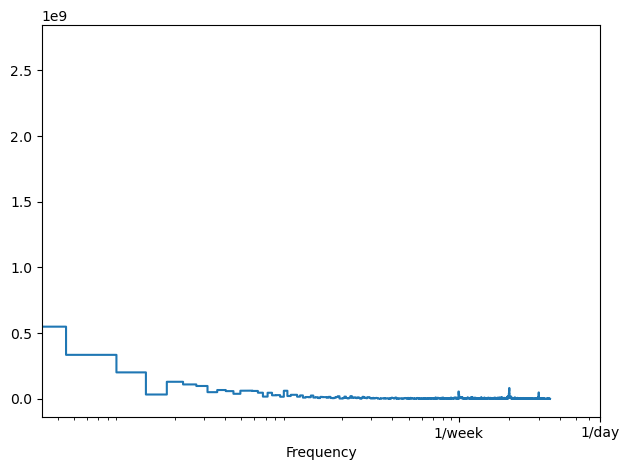

In [7]:
fft = tf.signal.rfft(df['Checkins'])
f_per_dataset = np.arange(0,len(fft))

n_sample = len(df['Checkins'])
weeks_per_dataset = n_sample / 7
f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [20]:
df.Date.describe()
df['Date'] = pd.to_datetime(df['Date'])

/var/folders/wz/44mfxs_n0fs5bcb4z1rph6dm0000gn/T/ipykernel_33660/1102791421.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.Date.describe()


In [24]:
timestamp_s = df.Date.map(datetime.timestamp)

day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

df.head()

,Unnamed: 0,Date,Checkins,day_sin,day_cos
0,99,2019-01-01,2202111,0.965926,0.258819
1,98,2019-01-02,2150571,0.965926,0.258819
2,97,2019-01-03,1975947,0.965926,0.258819
3,96,2019-01-04,2229391,0.965926,0.258819
4,95,2019-01-05,2044043,0.965926,0.258819


# Splitting data

In [33]:
df = df.drop(['Date'], axis=1)
df.head()

,Unnamed: 0,Checkins,day_sin,day_cos
0,99,2202111,0.965926,0.258819
1,98,2150571,0.965926,0.258819
2,97,1975947,0.965926,0.258819
3,96,2229391,0.965926,0.258819
4,95,2044043,0.965926,0.258819


In [34]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((1089, 4), (311, 4), (156, 4))

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1089 non-null   int64  
 1   Checkins    1089 non-null   int64  
 2   day_sin     1089 non-null   float64
 3   day_cos     1089 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 34.2 KB


In [36]:
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

/var/folders/wz/44mfxs_n0fs5bcb4z1rph6dm0000gn/T/ipykernel_33660/1038120894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
/var/folders/wz/44mfxs_n0fs5bcb4z1rph6dm0000gn/T/ipykernel_33660/1038120894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
/var/folders/wz/44mfxs_n0fs5bcb4z1rph6dm0000gn/T/ipykernel_33660/1038120894.py:6: SettingWithCopyWarning: 
A value i

# Deep Learning Models

## `DataWindow` class 

In [68]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        self.train_df = train_df 
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_to_input_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                        [labels[:,:,self.column_indices[name]] for name in self.label_columns], axis=-1
                    )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col='Checkins', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3,1,n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker = '.', zorder=-10)
            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (D)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,
                                                                 targets=None,
                                                                 sequence_length=self.total_window_size,
                                                                 sequence_stride=1,
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 )
        ds = ds.map(self.split_to_input_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [69]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [51]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline Models

In [70]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Checkins'])

### Repeat last value

In [71]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [72]:
baseline_last = MultiStepLastBaseline(label_index = column_indices['Checkins'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose = 0)

9/9 [==============================] - 0s 2ms/step - loss: 0.2105 - mean_absolute_error: 0.3596


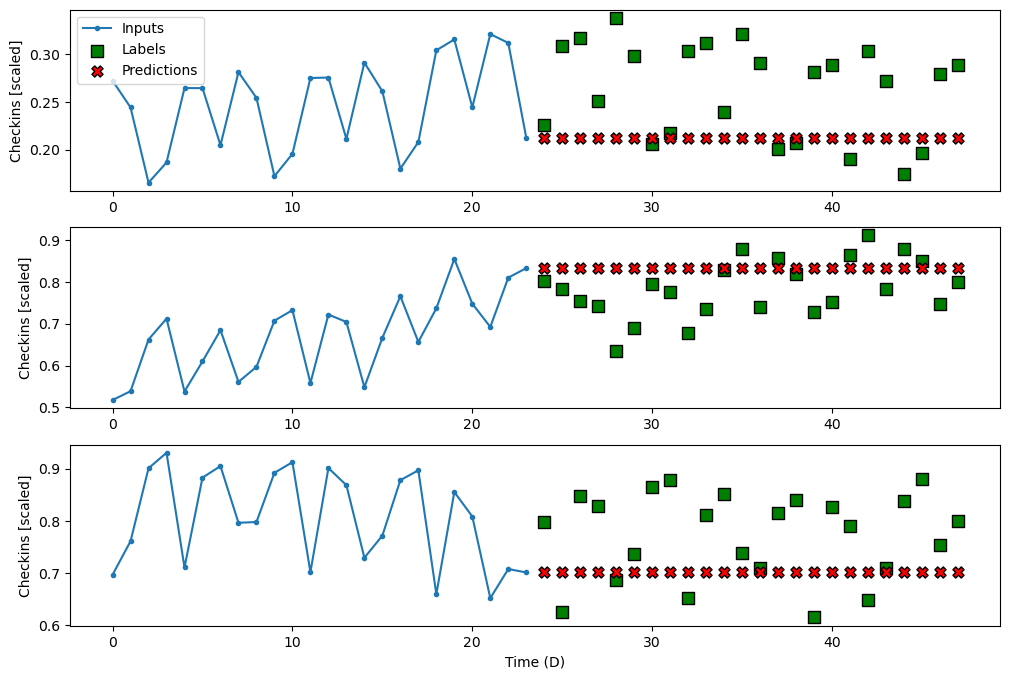

In [73]:
multi_window.plot(baseline_last)
plt.show()

### Repeat Last Day

In [74]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [75]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Checkins'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

9/9 [==============================] - 0s 2ms/step - loss: 0.2107 - mean_absolute_error: 0.3585


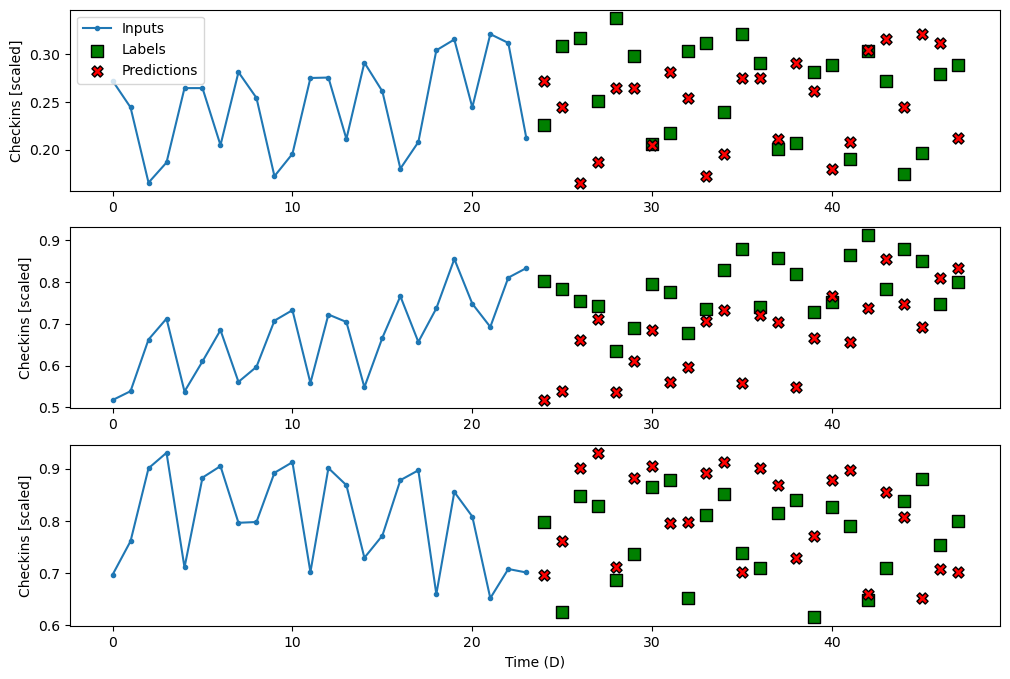

In [76]:
multi_window.plot(baseline_repeat)
plt.show()

### Linear Model

In [77]:
label_index = column_indices['Checkins']
num_features = train_df.shape[1]

linear = Sequential([Dense(1, kernel_initializer=tf.initializers.zeros)])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
33/33 [==============================] - 2s 11ms/step - loss: 0.3085 - mean_absolute_error: 0.4874 - val_loss: 0.3974 - val_mean_absolute_error: 0.6253
Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 0.2215 - mean_absolute_error: 0.4027 - val_loss: 0.2855 - val_mean_absolute_error: 0.5287
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1590 - mean_absolute_error: 0.3364 - val_loss: 0.2035 - val_mean_absolute_error: 0.4447
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1169 - mean_absolute_error: 0.2915 - val_loss: 0.1450 - val_mean_absolute_error: 0.3731
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0897 - mean_absolute_error: 0.2609 - val_loss: 0.1047 - val_mean_absolute_error: 0.3143
Epoch 6/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0730 - mean_absolute_error: 0.2389 - val_loss: 0.0773 - val_mean_absolute_error: 0.2671
Epoch 7/50
33/33 [=========

9/9 [==============================] - 0s 2ms/step - loss: 0.0135 - mean_absolute_error: 0.0933


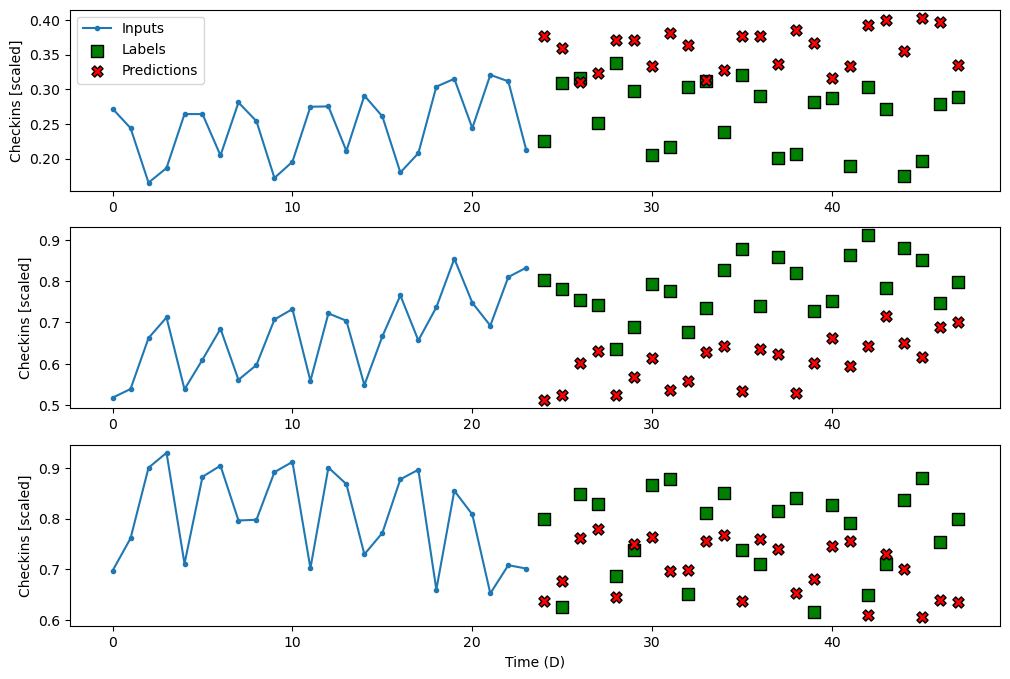

In [78]:
multi_window.plot(linear)
plt.show()

### CNN

In [79]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Checkins'])

In [80]:
cnn_model = Sequential([
    Conv1D(16, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
33/33 [==============================] - 1s 10ms/step - loss: 0.2611 - mean_absolute_error: 0.4390 - val_loss: 0.1639 - val_mean_absolute_error: 0.3980
Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0646 - mean_absolute_error: 0.2108 - val_loss: 0.0191 - val_mean_absolute_error: 0.1216
Epoch 3/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0397 - mean_absolute_error: 0.1664 - val_loss: 0.0138 - val_mean_absolute_error: 0.1005
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0293 - mean_absolute_error: 0.1365 - val_loss: 0.0092 - val_mean_absolute_error: 0.0770
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0236 - mean_absolute_error: 0.1163 - val_loss: 0.0093 - val_mean_absolute_error: 0.0763
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0206 - mean_absolute_error: 0.1054 - val_loss: 0.0097 - val_mean_absolute_error: 0.0783
Epoch 7/50
9/9 [===========

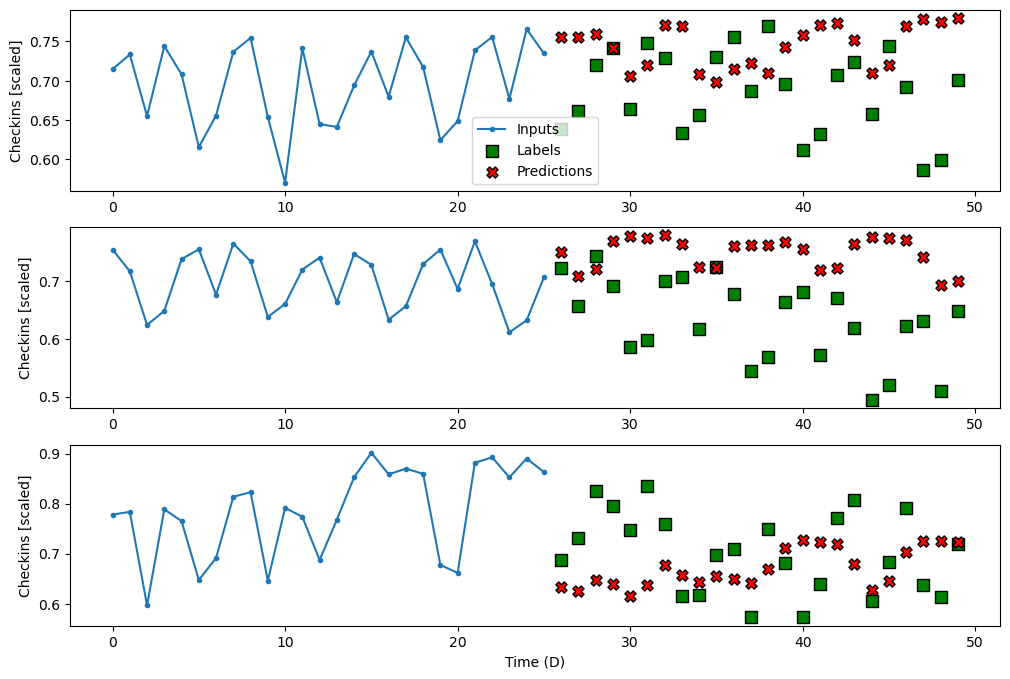

In [81]:
cnn_multi_window.plot(cnn_model)

plt.show()